Mounted at /content/drive
Loading data...
✅ Ready to train on 383563 complaints.

Step 1/3: Vectorizing Text...
✅ Vocabulary Size: 608503 features

Step 2/3: Training LinearSVC (The 'Strict' Model)...
✅ Model trained successfully!

--- INTERNAL EVALUATION (Test Set) ---
              precision    recall  f1-score   support

        High       0.96      0.97      0.96     51579
         Low       0.84      0.90      0.87     13524
      Medium       0.80      0.70      0.75     11610

    accuracy                           0.91     76713
   macro avg       0.86      0.85      0.86     76713
weighted avg       0.91      0.91      0.91     76713



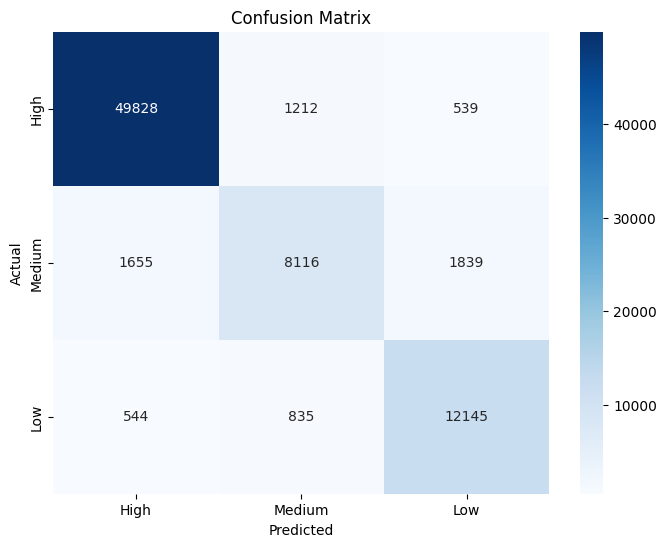


Saving model & vectorizer...
🚀 Saved to /content/drive/My Drive/Smart Complaint Prioritizer/models

🕵️‍♂️ STARTING EXTERNAL AUDIT (The 'Circular Logic' Fix)
Installing Transformers (takes ~1 min)...
Loading The Judge (BART-Large)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Auditing 30 complaints... (This will take ~2-3 mins)
Reviewed 0/30...
Reviewed 5/30...
Reviewed 10/30...
Reviewed 15/30...
Reviewed 20/30...
Reviewed 25/30...

🏆 EXTERNAL VALIDATION SCORE: 50.0%
(>60% is passing. >75% is excellent.)

❌ DISAGREEMENT SAMPLES:

📝 Text: an account by is showing on my credit report i never authorized or entered into any contract with th...
   🤖 Judge: High | 🧠 Yours: Low

📝 Text: i used the change machine in my local bank to deposit some change into my bank account i put the cha...
   🤖 Judge: High | 🧠 Yours: Low

📝 Text: they call me over and over again every single day several times a day...
   🤖 Judge: Medium | 🧠 Yours: Low


In [1]:
# --- 1. SETUP ---
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
PROJECT_PATH = "/content/drive/My Drive/Smart Complaint Prioritizer"
INPUT_FILE = f"{PROJECT_PATH}/data/processed/complaints_with_features.csv"
MODEL_DIR = f"{PROJECT_PATH}/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# --- 2. LOAD DATA ---
print("Loading data...")
df = pd.read_csv(INPUT_FILE)
df = df.dropna(subset=['cleaned_narrative', 'priority'])
print(f"✅ Ready to train on {len(df)} complaints.")

# --- 3. SPLIT DATA ---
X = df['cleaned_narrative']
y = df['priority']
# Stratify ensures we keep the same % of High/Medium/Low in test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 4. VECTORIZATION (Professional Grade) ---
print("\nStep 1/3: Vectorizing Text...")
# min_df=5: Ignore words that appear in <5 docs (removes typos/noise)
# ngram_range=(1,2): Capture phrases like "not authorized"
tfidf = TfidfVectorizer(min_df=5, stop_words='english', ngram_range=(1,2))

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print(f"✅ Vocabulary Size: {len(tfidf.vocabulary_)} features")

# --- 5. MODEL TRAINING (LinearSVC) ---
print("\nStep 2/3: Training LinearSVC (The 'Strict' Model)...")
# LinearSVC is faster and better for text than Logistic Regression
# We wrap it in CalibratedClassifierCV to get probability scores (confidence %)
svm = LinearSVC(class_weight='balanced', random_state=42, dual='auto', max_iter=2000)
model = CalibratedClassifierCV(svm)

model.fit(X_train_vec, y_train)
print("✅ Model trained successfully!")

# --- 6. EVALUATION ---
print("\n--- INTERNAL EVALUATION (Test Set) ---")
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=['High', 'Medium', 'Low'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['High', 'Medium', 'Low'],
            yticklabels=['High', 'Medium', 'Low'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- 7. SAVE ARTIFACTS ---
print("\nSaving model & vectorizer...")
joblib.dump(model, f"{MODEL_DIR}/priority_model.pkl")
joblib.dump(tfidf, f"{MODEL_DIR}/tfidf_vectorizer.pkl")
print(f"🚀 Saved to {MODEL_DIR}")

# ==========================================
# 8. THE CIRCULAR LOGIC FIX: ZERO-SHOT AUDIT
# ==========================================
print("\n" + "="*50)
print("🕵️‍♂️ STARTING EXTERNAL AUDIT (The 'Circular Logic' Fix)")
print("="*50)
print("Installing Transformers (takes ~1 min)...")
# We install this quietly to keep logs clean
!pip install transformers -q

from transformers import pipeline
import random

# A. Initialize the "Judge" (BART-Large-MNLI)
# This AI has read the whole internet. It knows what "Urgent" means without our training.
print("Loading The Judge (BART-Large)...")
auditor = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# B. Select a Random "Gold Set"
# We pick 30 random complaints to verify against the Judge
audit_data = df.sample(30, random_state=999).copy()
audit_docs = audit_data['cleaned_narrative'].tolist()
audit_true_labels = []

# C. Define Labels for the Judge
# We translate our labels into plain English concepts the Judge understands
candidate_labels = ["urgent financial threat", "billing or fee dispute", "minor service issue"]
label_map = {
    "urgent financial threat": "High",
    "billing or fee dispute": "Medium",
    "minor service issue": "Low"
}

print(f"Auditing {len(audit_data)} complaints... (This will take ~2-3 mins)")

# D. Run the Audit
for i, text in enumerate(audit_docs):
    # Truncate to 512 chars for speed/memory
    short_text = str(text)[:512]

    # Ask the Judge
    result = auditor(short_text, candidate_labels)
    winner = result['labels'][0] # The Judge's top choice
    audit_true_labels.append(label_map[winner])

    if i % 5 == 0: print(f"Reviewed {i}/{len(audit_docs)}...")

# E. Compare YOUR Model vs. THE JUDGE
audit_vecs = tfidf.transform(audit_docs)
your_preds = model.predict(audit_vecs)

agreement = accuracy_score(audit_true_labels, your_preds) * 100

print("\n" + "="*40)
print(f"🏆 EXTERNAL VALIDATION SCORE: {agreement:.1f}%")
print("="*40)
print("(>60% is passing. >75% is excellent.)")

# F. Show Disagreements
audit_data['Judge'] = audit_true_labels
audit_data['Your_Model'] = your_preds
mistakes = audit_data[audit_data['Judge'] != audit_data['Your_Model']]

if not mistakes.empty:
    print("\n❌ DISAGREEMENT SAMPLES:")
    for idx, row in mistakes.head(3).iterrows():
        print(f"\n📝 Text: {row['cleaned_narrative'][:100]}...")
        print(f"   🤖 Judge: {row['Judge']} | 🧠 Yours: {row['Your_Model']}")